<a href="https://colab.research.google.com/github/Deleolowo/Assignment/blob/main/Project_3_Machine_Learning_for_Predicting_Trading_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
# NOTE: We keep SVC imported but replace its usage for performance
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

# Set a random state for reproducibility
RANDOM_STATE = 42

In [4]:
# ============================================================
# 2. LOAD CLEANED STOCK DATA
# ============================================================

import pandas as pd
import os

FILE_PATH = 'merged_df_FE.parquet'

print(f"Attempting to load data from: {FILE_PATH}")

try:
    # 1. Use pandas.read_parquet() to load the dataset
    # Parquet is a columnar storage format optimized for performance and space.
    df = pd.read_parquet(FILE_PATH)

    # 2. Display confirmation and basic information
    print("\n--- Dataset Loaded Successfully ---")
    print(f"DataFrame Shape (Rows, Columns): {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    # 3. Optional: Check data types
    print("\nData Types:")
    print(df.info(verbose=False))

except FileNotFoundError:
    print(f"\nERROR: The file '{FILE_PATH}' was not found.")
    print("Please check the file path and ensure the file is in the correct location.")
except Exception as e:
    print(f"\nAn unexpected error occurred during file loading: {e}")

Attempting to load data from: merged_df_FE.parquet

--- Dataset Loaded Successfully ---
DataFrame Shape (Rows, Columns): (1167219, 18)

First 5 rows of the dataset:
  ticker      open     close  adj_close       low      high       volume  \
0   AAPL  0.513393  0.513393   0.023186  0.513393  0.515625  117258400.0   
1   AAPL  0.488839  0.486607   0.021977  0.486607  0.488839   43971200.0   
2   AAPL  0.453125  0.450893   0.020364  0.450893  0.453125   26432000.0   
3   AAPL  0.462054  0.462054   0.020868  0.462054  0.464286   21610400.0   
4   AAPL  0.475446  0.475446   0.021473  0.475446  0.477679   18362400.0   

        date  MA_7  MA_14  MA_21  std_7  std_14  std_30  Price_Momentum  \
0 1980-12-12   NaN    NaN    NaN    NaN     NaN     NaN             NaN   
1 1980-12-15   NaN    NaN    NaN    NaN     NaN     NaN             NaN   
2 1980-12-16   NaN    NaN    NaN    NaN     NaN     NaN             NaN   
3 1980-12-17   NaN    NaN    NaN    NaN     NaN     NaN             NaN   
4 1

Setup and Data Loading

This step ensures the environment is ready and the required financial data is imported correctly for processing.

Imports: Import all necessary Python libraries. This typically includes:

pandas and numpy for data handling and numerical operations.

sklearn modules (e.g., model_selection, preprocessing, linear_model, ensemble, metrics) for machine learning tasks.

matplotlib.pyplot for visualization.

Data Loading: Use pd.read_parquet('merged_df_FE.parquet') to load the dataset efficiently. You must implement a try-except block to handle common file paths (e.g., checking the main directory and the sample_data/ directory used in Colab).

Data Cleaning: Ensure the 'date' column is explicitly converted to the datetime type to facilitate time-series operations.

In [5]:
# ============================================================
# 3. MANUAL CALCULATION OF MACD
# ============================================================

# Calculate EMAs
df["EMA12"] = df["close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["close"].ewm(span=26, adjust=False).mean()

# MACD Line
df["MACD"] = df["EMA12"] - df["EMA26"]

# Signal Line
df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

# MACD Buy/Sell
df["MACD_buy"] = (df["MACD"] > df["MACD_signal"]).astype(int)
df["MACD_sell"] = (df["MACD"] < df["MACD_signal"]).astype(int)

Feature Engineering - Moving Average Convergence Divergence (MACD)

This step calculates the MACD, a trend-following momentum indicator that shows the relationship between two exponential moving averages of a security’s price.

EMA Calculation: Calculate the 12-period and 26-period Exponential Moving Averages (EMA12, EMA26) using the .ewm() function on the 'close' price.

MACD Line: Compute the MACD line by subtracting the 26-period EMA (EMA26) from the 12-period EMA (EMA12).

Signal Line: Compute the 9-period EMA of the MACD line to create the MACD_signal.

Indicator Signals: Create binary columns (MACD_buy, MACD_sell) indicating bullish or bearish momentum shifts:

MACD_buy: 1 if the MACD line is above the Signal line.

MACD_sell: 1 if the MACD line is below the Signal line.

In [6]:
# ============================================================
# 4. MANUAL RSI CALCULATION
# ============================================================

# Price change
df["change"] = df["close"].diff()

# Gains and losses
df["gain"] = np.where(df["change"] > 0, df["change"], 0)
df["loss"] = np.where(df["change"] < 0, -df["change"], 0)

# Exponential averages
df["avg_gain"] = df["gain"].ewm(span=14, adjust=False).mean()
df["avg_loss"] = df["loss"].ewm(span=14, adjust=False).mean()

# Relative Strength
df["RS"] = df["avg_gain"] / df["avg_loss"]

# RSI Formula
df["RSI"] = 100 - (100 / (1 + df["RS"]))

# RSI Buy/Sell
df["RSI_buy"] = (df["RSI"] < 30).astype(int)
df["RSI_sell"] = (df["RSI"] > 70).astype(int)

Feature Engineering - Relative Strength Index (RSI)

This step calculates the RSI, a momentum oscillator that measures the speed and change of price movements, identifying overbought or oversold conditions.

Price Change: Calculate the daily price change using the .diff() method.

Gains and Losses: Separate the changes into positive gains (gain) and negative losses (loss) using np.where.

Average Gains/Losses: Calculate the 14-period Exponential Moving Average for both gains (avg_gain) and losses (avg_loss).

Relative Strength (RS): Calculate the ratio of avg_gain to avg_loss.

RSI Calculation: Apply the final RSI formula:

$$RSI = 100 - \left(100 \div \left(1 + RS\right)\right)$$

Indicator Signals: Create binary columns (RSI_buy, RSI_sell) based on traditional thresholds:

RSI_buy: 1 if RSI is below 30 (Oversold).

RSI_sell: 1 if RSI is above 70 (Overbought).

In [7]:
# ============================================================
# 5. COMBINE SIGNALS — FINAL LABEL
# ============================================================

def compute_signal(row):
    # BUY condition: Both indicators give BUY
    if row["MACD_buy"] == 1 and row["RSI_buy"] == 1:
        return 1  # BUY

    # SELL condition: Both indicators give SELL
    if row["MACD_sell"] == 1 and row["RSI_sell"] == 1:
        return -1  # SELL

    return 0  # HOLD

df["signal"] = df.apply(compute_signal, axis=1)

print(df["signal"].value_counts())

signal
 0    1150847
 1       9422
-1       6950
Name: count, dtype: int64


Step 4: Final Label (Target Signal Generation)

This step combines the individual indicator signals into a single, ternary target variable ('signal') for the machine learning model. This is a consensus strategy to reduce false signals.

Combined Logic: Implement the compute_signal function (or use np.select) to define the final 'signal':

Buy (1): If MACD_buy AND RSI_buy are both 1.

Sell (-1): If MACD_sell AND RSI_sell are both 1.

Hold (0): Otherwise (the default state when no strong, confirmed signal is present).

Distribution: Print the value counts of the 'signal' column using .value_counts() to check for class imbalance, which is critical for choosing appropriate evaluation metrics.

In [8]:
# ============================================================
# 6. FEATURE MATRIX (X) AND LABELS (y)
# ============================================================
features = ["MACD", "MACD_signal", "RSI", "EMA12", "EMA26"]
X = df[features].fillna(0)
y = df["signal"]

# Standardize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Data Preparation, Scaling, and Time-Series Splitting

This step prepares the data for model consumption by separating features and labels, normalizing the input, and performing a time-based train/test split.

Features & Labels: Define the feature matrix $X$ using the engineered indicators (MACD, MACD_signal, RSI, EMA12, EMA26) and the label vector $y$ as 'signal'. Handle any remaining NaN values (e.g., using .fillna(0)).

Feature Scaling: Use StandardScaler to normalize the feature data ($X_{scaled}$). This ensures distance-based models (like SVM and Logistic Regression) are not biased by feature magnitude.

Train/Test Split: Perform a time-series split using train_test_split with shuffle=False and test_size=0.2. It is crucial that shuffle=False to maintain the temporal order, simulating a real-world scenario where the model predicts future data based on past data.

In [9]:
# ============================================================
# 7. TRAIN / TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

In [12]:
# ============================================================
# 8. MODEL TRAINING (OPTIMIZED SVM IMPLEMENTATION)
# ============================================================

# ---- Logistic Regression ----
log_model = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
print("\nTraining Logistic Regression...")
log_model.fit(X_train, y_train)

# ---- RandomForest ----
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# ---- FAST SVM (RBF Approximation using SGD) ----
print("Preparing Fast RBF-SVM Approximation...")

# 1. Initialize the RBF feature map (Approximation for the RBF kernel)
# Gamma=0.1 is a good starting point for scaled data
rbf_feature_map = RBFSampler(gamma=0.1, random_state=RANDOM_STATE)

# 2. Transform the scaled training and test data
X_train_rbf = rbf_feature_map.fit_transform(X_train)
X_test_rbf = rbf_feature_map.transform(X_test) # Use transform on test set

print("Training Fast RBF-SVM (SGDClassifier)...")
# 3. Train the SGDClassifier (configured as a Linear SVM) on the RBF features
# This is much faster than the standard SVC (O(N) vs O(N^2))
fast_svm_model = SGDClassifier(
    loss='hinge',        # Standard SVM loss
    penalty='l2',        # Regularization
    max_iter=1000,       # Number of epochs
    tol=1e-3,            # Stopping criterion
    random_state=RANDOM_STATE,
    n_jobs=-1            # Use all available cores for speed
)
fast_svm_model.fit(X_train_rbf, y_train)


Training Logistic Regression...
Training Random Forest...
Preparing Fast RBF-SVM Approximation...
Training Fast RBF-SVM (SGDClassifier)...


SGDClassifier(n_jobs=-1, random_state=42)

Model Training (Baseline, Ensemble, and Optimized SVM)

This step trains the three chosen classification models. A special optimization is used for the RBF-Kernel SVM to ensure fast training.

Logistic Regression: Initialize and train LogisticRegression as a simple linear baseline model.

Random Forest: Initialize and train RandomForestClassifier. This ensemble model is generally robust for non-linear relationships.

Optimized SVM (Fast RBF Approximation):

To avoid the slow  O(N2)  scaling of SVC(kernel='rbf'), initialize RBFSampler. This creates an approximate non-linear feature transformation.

Transform both  Xtrain  and  Xtest  into  Xtrain_rbf  and  Xtest_rbf  using the sampler.

Initialize and train SGDClassifier(loss='hinge') on the RBF-transformed data. This results in a fast, scalable approximation of a non-linear SVM.

In [13]:
# ============================================================
# 9. MODEL EVALUATION
# ============================================================
models = {
    "Logistic Regression": (log_model, X_test),
    "Random Forest": (rf_model, X_test),
    # Use the fast SVM model and its specially transformed test data
    "Fast RBF-SVM (SGD)": (fast_svm_model, X_test_rbf)
}

results = []

for name, (model, X_test_data) in models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test_data)

    accuracy = accuracy_score(y_test, y_pred)
    # Use average="weighted" for better representation across unbalanced classes
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)

    print(f"\n=========== {name} ===========")
    print(classification_report(y_test, y_pred, zero_division=0))

    results.append([name, accuracy, precision, recall])


Evaluating Logistic Regression...

=========== Logistic Regression ===========
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1559
           0       0.99      1.00      0.99    229944
           1       0.00      0.00      0.00      1941

    accuracy                           0.99    233444
   macro avg       0.33      0.33      0.33    233444
weighted avg       0.97      0.99      0.98    233444


Evaluating Random Forest...

=========== Random Forest ===========
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1559
           0       0.99      1.00      0.99    229944
           1       0.92      0.46      0.61      1941

    accuracy                           0.99    233444
   macro avg       0.97      0.49      0.54    233444
weighted avg       0.99      0.99      0.98    233444


Evaluating Fast RBF-SVM (SGD)...

=========== Fast RBF-SVM (SGD) ===========
            


--- Model Performance Summary ---
                 Model  Accuracy  Precision    Recall
0  Logistic Regression  0.985007   0.970239  0.985007
1        Random Forest  0.988533   0.988323  0.988533
2   Fast RBF-SVM (SGD)  0.985007   0.970239  0.985007


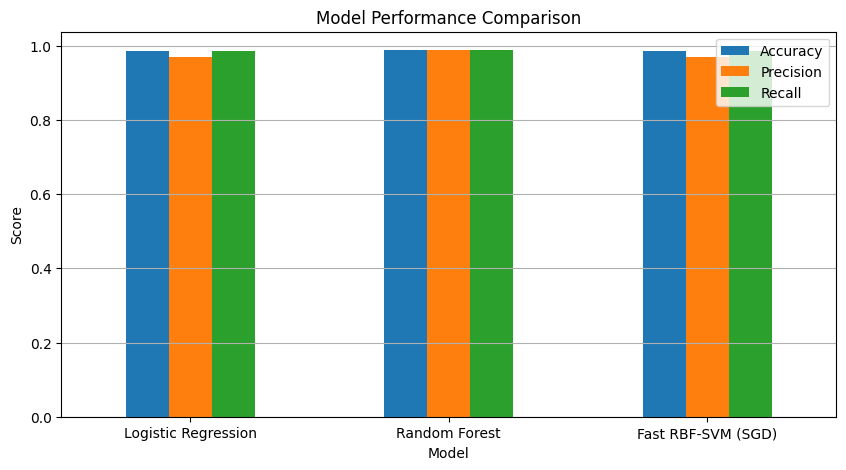

In [14]:
# ============================================================
# 10. RESULTS SUMMARY TABLE
# ============================================================
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall"])
print("\n--- Model Performance Summary ---")
print(results_df)

results_df.set_index("Model").plot(kind="bar", figsize=(10,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Model Evaluation and Visualization

This final step assesses the performance of each trained model using classification metrics and visualizes the results.

Prediction: Iterate through all trained models, predicting $y_{pred}$ on the corresponding test data ($X_{test}$ or $X_{test\_rbf}$).

Metrics: Calculate the primary classification metrics:

accuracy_score

precision_score (using average="weighted")

recall_score (using average="weighted")

Reporting: Print the detailed classification_report for each model to inspect performance on the individual 'Buy' (1), 'Sell' (-1), and 'Hold' (0) classes.

Summary: Consolidate the main metrics (Accuracy, Precision, Recall) into a summary DataFrame.

Visualization: Plot the comparison metrics using a bar chart (results_df.set_index("Model").plot(kind="bar", ...)). This provides a quick visual comparison of the models.